# PreProcessing

Data provided in the dataset include:
* _Data_Entry_2017.csv_ containing information of the patients, mappings of the images to those information and to actual diagnosis labels
* _train_val_list.txt_ containing list of image file names that should be used for training and validation
* _test_list.txt_ containing list of image file names that should be used for testing
* Actual images of size 1024px * 1024px

#### First define file folder location & load them 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FILE_FOLDER = '../data/'

print("__________Data Entry sheet__________")
raw_data = pd.read_csv(FILE_FOLDER + 'Data_Entry_2017.csv', header=0)
print("Total number of rows: " + str(len(raw_data))) #112120
print("Samples:")
print(raw_data[:3])
print("\n\n")

print("__________Train & Validation list__________")
train_val_list = pd.read_csv(FILE_FOLDER + 'train_val_list.txt', header=None)
print("Total number of rows: " + str(len(train_val_list))) #86524
print("Samples:")
print(train_val_list[:3])
print("\n\n")

print("__________Test list__________")
test_list = pd.read_csv(FILE_FOLDER + 'test_list.txt', header=None)
print("Total number of rows: " + str(len(test_list))) #25596
print("Samples:")
print(test_list[:3])

__________Data Entry sheet__________
Total number of rows: 112120
Samples:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  



__________Train & Validation list__________
Total number of rows: 86524
Samples:
                  0
0  00000001

#### Some statistic over the raw data

In [17]:
raw_data_by_patient = raw_data[['Patient ID','Patient Age','Patient Gender']].drop_duplicates()

print("Number of patients          : " + str(len(raw_data_by_patient))) #46115
print("Age Range                   : " + str(min(raw_data_by_patient['Patient Age'])) + \
      " to " + str(max(raw_data_by_patient['Patient Age'])) ) #1 to 414
print("Number of images per patient: " + str(min(raw_data.groupby(['Patient ID'])['Image Index'].count())) + \
      " to " + str(max(raw_data.groupby(['Patient ID'])['Image Index'].count())) ) #1 to 184
print("Male patients               : " + str(len(raw_data_by_patient[raw_data_by_patient['Patient Gender'] == 'M']))) #24651
print("Male patient images         : " + str(len(raw_data[raw_data['Patient Gender'] == 'M']))) #63340
print("Female patients             : " + str(len(raw_data_by_patient[raw_data_by_patient['Patient Gender'] == 'F']))) #21464
print("Female patient images       : " + str(len(raw_data[raw_data['Patient Gender'] == 'F']))) #48780

Number of patients          : 46115
Age Range                   : 1 to 414
Number of images per patient: 1 to 184
Male patients               : 24651
Male patient images         : 63340
Female patients             : 21464
Female patient images       : 48780


#### Binarize image diagnosis labels

List set of unique diagnosis labels and count their occurences

All labels: No Finding, Cardiomegaly, Hernia, Nodule, Atelectasis, Mass, Consolidation, Effusion, Pneumonia, Emphysema, Fibrosis, Pneumothorax, Edema, Infiltration, Pleural_Thickening

Plotting label counts:


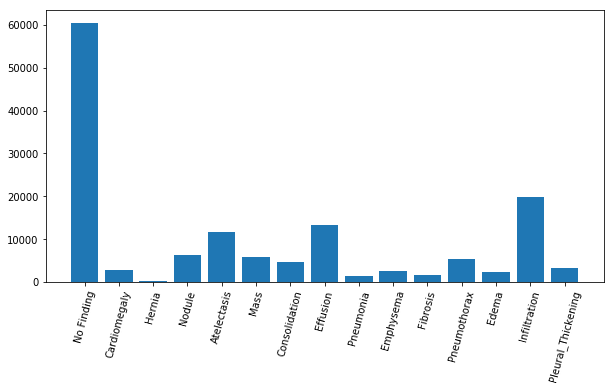

In [23]:
unique_labels = set([item for x in raw_data['Finding Labels'] for item in x.split('|')])
unique_labels = list(unique_labels)
print("All labels: " + ', '.join(unique_labels))

label_count = []
for each in unique_labels:
    label_count.append(len(raw_data[raw_data['Finding Labels'].str.contains(each)]))

print()
print("Plotting label counts:")
plt.figure(figsize=(10,5))
plt.bar(unique_labels, label_count)
plt.xticks(rotation=75)
plt.show()

Binarize labels of images to diagnosis columns. _No Finding_ cases are represented as all 0s on all diagnosis columns.
(Since we only concern with classify diagnosis from X-ray image in this project, all other columns are dropped as well)

In [26]:
# drop 'No Finding' labels
unique_labels.remove('No Finding')

# drop other columns in raw data but image file name and labels
data = raw_data.loc[:,'Image Index':'Finding Labels']
data.columns = ['image','labels']

# define function to binarize label
def binarize_labels(labels, binarize_string):
    if binarize_string in labels['labels'].split('|'):
        return 1
    else:
        return 0

# binarize label in DataFrame
for each in unique_labels:
    data[each] = data.apply(func=binarize_labels, binarize_string=each, axis=1)

print("Data sample: ")
print(data[:3])

# drop string label column
data = data.drop('labels', axis=1)

Data sample: 
              image                  labels  Cardiomegaly  Hernia  Nodule  \
0  00000001_000.png            Cardiomegaly             1       0       0   
1  00000001_001.png  Cardiomegaly|Emphysema             1       0       0   
2  00000001_002.png   Cardiomegaly|Effusion             1       0       0   

   Atelectasis  Mass  Consolidation  Effusion  Pneumonia  Emphysema  Fibrosis  \
0            0     0              0         0          0          0         0   
1            0     0              0         0          0          1         0   
2            0     0              0         1          0          0         0   

   Pneumothorax  Edema  Infiltration  Pleural_Thickening  
0             0      0             0                   0  
1             0      0             0                   0  
2             0      0             0                   0  


Merge binarized image data with train/validation list and test list to create labeled DataFrames.

In [28]:
train_val_list.columns = ['image']
train_val_data = pd.merge(train_val_list, data, left_on='image', right_on='image', how='inner')
test_list.columns = ['image']
test_data = pd.merge(test_list, data, left_on='image', right_on='image', how='inner')

print("Train/validation list samples:")
print(train_val_data[:3])
print()
print("Test list samples:")
print(test_data[:3])

Train/validation list sample:
              image  Cardiomegaly  Hernia  Nodule  Atelectasis  Mass  \
0  00000001_000.png             1       0       0            0     0   
1  00000001_001.png             1       0       0            0     0   
2  00000001_002.png             1       0       0            0     0   

   Consolidation  Effusion  Pneumonia  Emphysema  Fibrosis  Pneumothorax  \
0              0         0          0          0         0             0   
1              0         0          0          1         0             0   
2              0         1          0          0         0             0   

   Edema  Infiltration  Pleural_Thickening  
0      0             0                   0  
1      0             0                   0  
2      0             0                   0  

Test list sample:
              image  Cardiomegaly  Hernia  Nodule  Atelectasis  Mass  \
0  00000003_000.png             0       1       0            0     0   
1  00000003_001.png             0

#### Split training/validation data by 80/20 ratio and save the lists

In [29]:
msk = np.random.rand(len(train_val_data)) < 0.8
train_data = train_val_data[msk]
val_data = train_val_data[~msk]

# save files to folder
train_data.to_csv(FILE_FOLDER + 'train_list.csv', index=False)
val_data.to_csv(FILE_FOLDER + 'val_list.csv', index=False)
test_data.to_csv(FILE_FOLDER + 'test_list.csv', index=False)

# save labels file
with open(FILE_FOLDER + 'labels.txt','w') as f:
    f.write('\n'.join(unique_labels))

# a small test set was also created for demoing/testing local files purpose
#test_data_sample = test_data_sample.sample(n=64,frac=None)
#test_data_sample.to_csv(FILE_FOLDER + 'test_list_sample.csv', index=False)
test_data_sample = pd.read_csv(FILE_FOLDER + 'test_list_sample.csv', header=0)

#### Explore images

In this project, image data will be stored and retrieved from an S3 bucket. We can retrieve some sample images and display them along with their labels.
For demo purpose, we instead sample from the local files in below section.

Image samples:


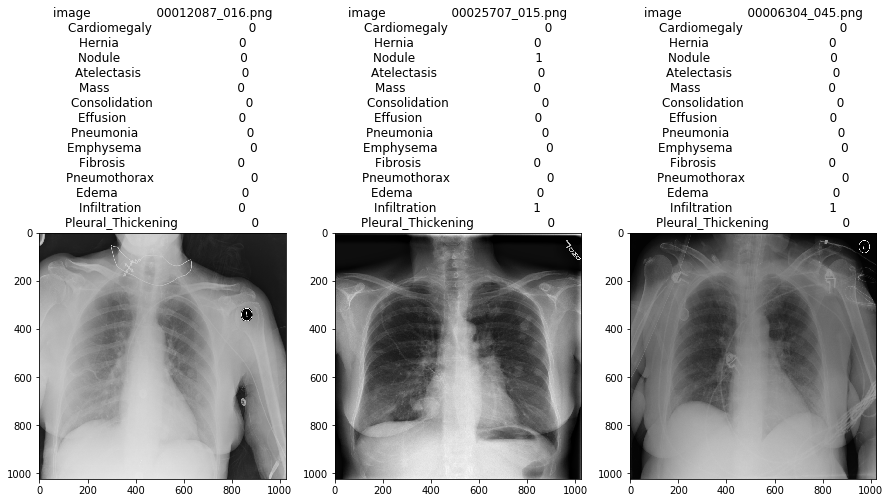

In [74]:
import imageio

IMAGE_FOLDER = '../data/images/'

print("Image samples:")

# define function to get image file and information
def loadImagesFromLocal(folder, images):
    result_images = []
    result_labels = []
    for index, row in images.iterrows():
        file_path = IMAGE_FOLDER + row['image']
        with open(file_path, 'rb') as f:
            rgb_imgbytes = imageio.imread(file_path, pilmode='RGB')
            result_images.append(rgb_imgbytes)
        result_labels.append(row.to_string())
    return (result_images, result_labels)

sample_images = loadImagesFromLocal(IMAGE_FOLDER, test_data_sample.sample(n=3,frac=None))

# create figure with sub-plots
fig, axes = plt.subplots(1, 3, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[0][i])
    ax.set_title(sample_images[1][i])
plt.show()        

Alternatively, to sample from test files in S3 bucket:

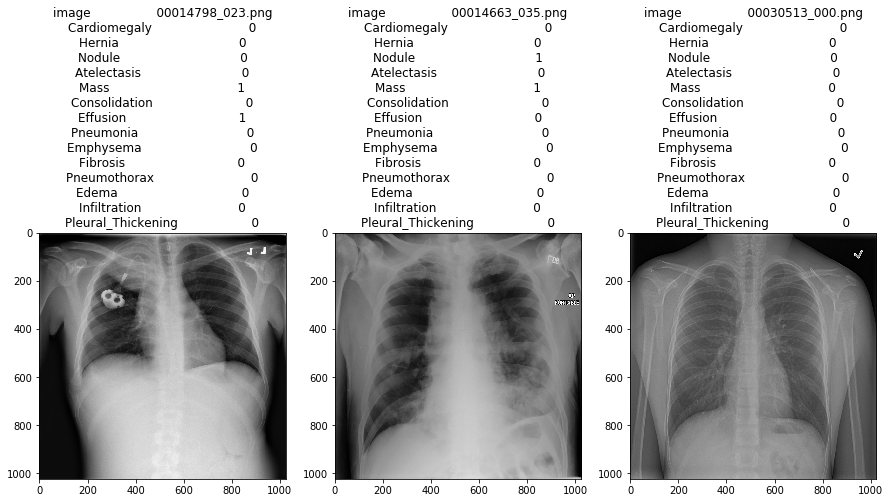

In [72]:
import boto3
import tempfile

BUCKET_NAME = 'cse6250-chestxray'
IMAGE_IN_BUCKET = 'images/'

s3 = boto3.resource('s3')
bucket = s3.Bucket(BUCKET_NAME)

# define function to get image file and information
def loadImagesFromS3(s3bucket, path, images):
    result_images = []
    result_labels = []
    for index, row in images.iterrows():
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            s3bucket.download_fileobj(path + row['image'], f)
            # convert grayscale to rgb.
            rgb_imgbytes = imageio.imread(tmp.name, pilmode='RGB')
            result_images.append(rgb_imgbytes)
        result_labels.append(row.to_string())
    return (result_images, result_labels)

# sample images from test set
sample_images = loadImagesFromS3(bucket, IMAGE_IN_BUCKET, test_data.sample(n=3,frac=None))

# create figure with sub-plots
fig, axes = plt.subplots(1, 3, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[0][i])
    ax.set_title(sample_images[1][i])
plt.show()    